<a href="https://colab.research.google.com/github/yamrajkhadka/Land-Cover-Classification-from-Satellite-Images-using-U-Net-on-the-DeepGlobe-Dataset/blob/main/DeepGlobe_LandCoverSegmentation_U-Net_yamraj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install necessary libraries
!pip install kaggle
# Set up Kaggle API credentials
import os
os.environ['KAGGLE_USERNAME'] = 'yamrajkhadka01'
os.environ['KAGGLE_KEY'] = '/content/kaggle (5).json'
# Download the dataset
!kaggle datasets download -d balraj98/deepglobe-land-cover-classification-dataset -p /content/
# Unzip the dataset
!unzip -q /content/deepglobe-land-cover-classification-dataset.zip -d /content/deepglobe_dataset/

Dataset URL: https://www.kaggle.com/datasets/balraj98/deepglobe-land-cover-classification-dataset
License(s): other
100% 2.73G/2.74G [00:33<00:00, 221MB/s]
100% 2.74G/2.74G [00:33<00:00, 88.9MB/s]


In [ ]:
# === Imports (same as before) ===
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import albumentations as A

# === 1. Load Class Mapping ===
CLASS_DICT_CSV = '/content/deepglobe_dataset/class_dict.csv'
class_dict = pd.read_csv(CLASS_DICT_CSV)
color2class = {(row['r'], row['g'], row['b']): idx for idx, row in class_dict.iterrows()}
NUM_CLASSES = len(class_dict)

def rgb_to_class(mask_rgb):
    h, w, _ = mask_rgb.shape
    mask_class = np.zeros((h, w), dtype=np.uint8)
    for color, class_idx in color2class.items():
        matches = np.all(mask_rgb == color, axis=-1)
        mask_class[matches] = class_idx
    return mask_class

# === 2. Load Dataset and Augment ===
TRAIN_IMG_DIR = '/content/deepglobe_dataset/train'
IMG_SIZE = (224, 224)
img_ids = [f[:-8] for f in os.listdir(TRAIN_IMG_DIR) if f.endswith('_sat.jpg')]

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=20, p=0.5),
    A.ElasticTransform(p=0.2), #to improve the generalization the model by teaching it in well unseen new data not just memorizing the training img
])

X, Y = [], []
for img_id in img_ids:
    img = cv2.imread(os.path.join(TRAIN_IMG_DIR, f"{img_id}_sat.jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(os.path.join(TRAIN_IMG_DIR, f"{img_id}_mask.png"))
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

    augmented = transform(image=img, mask=mask)
    img = cv2.resize(augmented['image'], IMG_SIZE)
    mask = cv2.resize(augmented['mask'], IMG_SIZE, interpolation=cv2.INTER_NEAREST)

    img = img / 255.0
    mask_class = rgb_to_class(mask)
    mask_onehot = to_categorical(mask_class, num_classes=NUM_CLASSES)

    X.append(img)
    Y.append(mask_onehot)

X = np.array(X, dtype=np.float32)
Y = np.array(Y, dtype=np.float32)

# === 3. Class Weights (focus more on class 2 and 5) === if we treat all class equally,the model will ignore the minority class because it gets high accuracy
                                                    #=== just by pridicting the dominant class
flat_mask = np.argmax(Y, axis=-1).reshape(-1) # Convert one-hot masks to a flat array of class indices for all pixels across the dataset
class_counts = np.bincount(flat_mask, minlength=NUM_CLASSES) # counts how many pixels belongs each class
class_weights = class_counts.max() / (class_counts + 1e-6) #giving more imp to rare class by assigning higher weights
class_weights[[2, 5]] *= 2  # Boost weight for underperforming classes
class_weights = class_weights / class_weights.sum() * NUM_CLASSES

# === 4. Custom Composite Loss ===
def focal_tversky_loss(alpha=0.7, beta=0.3, gamma=0.75): # used when there is class imbalance — where some objects are much smaller or rarer than others.
                                                         # Defines a loss that balances false positives(gives panalty for over predict a class)
                                                        #and false negatives(for missing the detected obj), and focuses more on hard-to-classify pixels

    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)#to avoid log(0) and division by 0 and prediction in that range
        TP = tf.reduce_sum(y_true * y_pred, axis=[1, 2])
        FP = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2])
        FN = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2])
        tversky = (TP + 1e-6) / (TP + alpha * FP + beta * FN + 1e-6)
        return tf.reduce_mean(tf.pow((1 - tversky), gamma))
    return loss

def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    def loss(y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0)
        loss = -tf.reduce_sum(y_true * tf.math.log(y_pred) * weights, axis=-1)
        return tf.reduce_mean(loss)
    return loss

def combined_loss_fn(y_true, y_pred):
    wce = weighted_categorical_crossentropy(class_weights)(y_true, y_pred)
    ftl = focal_tversky_loss()(y_true, y_pred)
    return 0.4 * wce + 0.6 * ftl

# === 5. Metric ===
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super().__init__(num_classes=num_classes, name=name, **kwargs)
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

# === 6. U-Net Model ===
def build_unet(input_shape=(224, 224, 3), num_classes=NUM_CLASSES):
    def conv_block(x, filters):
        x = Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        x = Conv2D(filters, 3, padding='same', activation='relu')(x)
        x = BatchNormalization()(x)
        return x

    inputs = Input(input_shape)
    c1 = conv_block(inputs, 32); p1 = MaxPooling2D()(c1)
    c2 = conv_block(p1, 64); p2 = MaxPooling2D()(c2)
    c3 = conv_block(p2, 128); p3 = MaxPooling2D()(c3)
    c4 = conv_block(p3, 256); p4 = MaxPooling2D()(c4)
    b = conv_block(p4, 512); b = Dropout(0.5)(b)
    u1 = Conv2DTranspose(256, 2, strides=2, padding='same')(b); u1 = concatenate([u1, c4]); c5 = conv_block(u1, 256)
    u2 = Conv2DTranspose(128, 2, strides=2, padding='same')(c5); u2 = concatenate([u2, c3]); c6 = conv_block(u2, 128)
    u3 = Conv2DTranspose(64, 2, strides=2, padding='same')(c6); u3 = concatenate([u3, c2]); c7 = conv_block(u3, 64)
    u4 = Conv2DTranspose(32, 2, strides=2, padding='same')(c7); u4 = concatenate([u4, c1]); c8 = conv_block(u4, 32)
    outputs = Conv2D(num_classes, 1, activation='softmax')(c8)
    return Model(inputs, outputs)

model = build_unet()
model.compile(optimizer='adam', loss=combined_loss_fn, metrics=[MeanIoU(NUM_CLASSES)])

# === 7. Training ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-5)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(
    X, Y,
    validation_split=0.2,
    epochs=200,
    batch_size=8,
    shuffle=True,
    callbacks=[reduce_lr, early_stop],
    verbose=1
)

# === 8. Per-Class IoU ===
preds = model.predict(X)
preds_class = np.argmax(preds, axis=-1)
true_class = np.argmax(Y, axis=-1)

ious = []
for i in range(NUM_CLASSES):
    intersection = np.logical_and(preds_class == i, true_class == i).sum()
    union = np.logical_or(preds_class == i, true_class == i).sum()
    iou = intersection / (union + 1e-6)
    ious.append(iou)
    print(f"Class {i} IoU: {iou:.4f}")
print("Mean IoU:", np.mean(ious))


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch 1/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 56s 360ms/step - loss: 0.9254 - mean_iou: 0.1964 - val_loss: 2.3785 - val_mean_iou: 0.0202 - learning_rate: 0.0010
Epoch 2/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - loss: 0.8051 - mean_iou: 0.3254 - val_loss: 1.2608 - val_mean_iou: 0.0198 - learning_rate: 0.0010
Epoch 3/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 12s 153ms/step - loss: 0.7700 - mean_iou: 0.3487 - val_loss: 2.7642 - val_mean_iou: 0.0220 - learning_rate: 0.0010
Epoch 4/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 152ms/step - loss: 0.7616 - mean_iou: 0.3455 - val_loss: 2.1825 - val_mean_iou: 0.0116 - learning_rate: 0.0010
Epoch 5/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 0.7487 - mean_iou: 0.3610 - val_loss: 1.0645 - val_mean_iou: 0.1479 - learning_rate: 0.0010
Epoch 6/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - loss: 0.7521 - mean_iou: 0.3829 - val_loss: 0.8660 - val_mean_iou: 0.1417 - learning_rate: 0.0010
Epoch 7/200
81/81 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - loss: 0.7311 - mean_

Showing predictions for 3 random images:


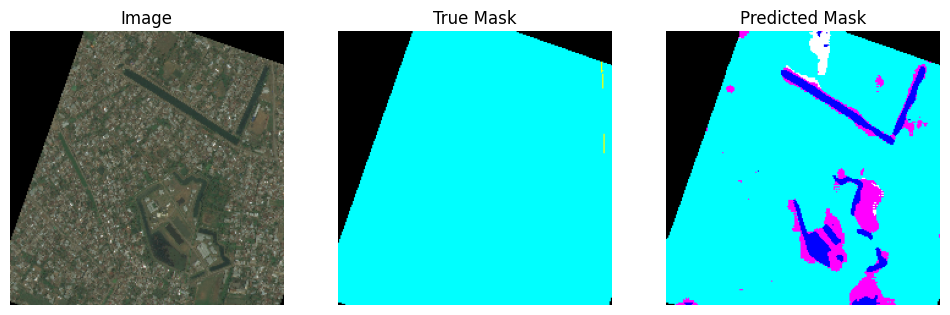

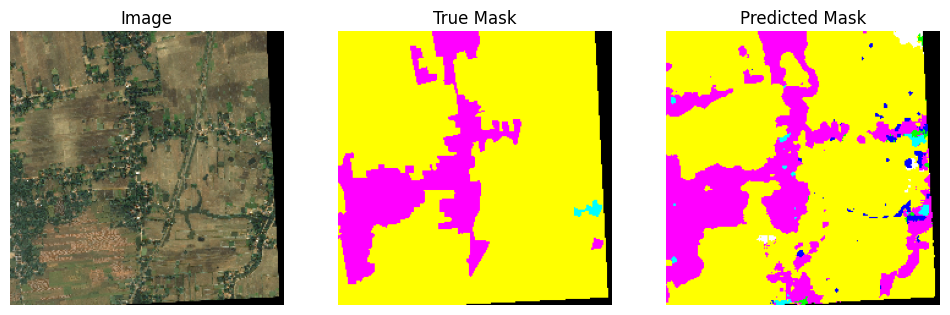

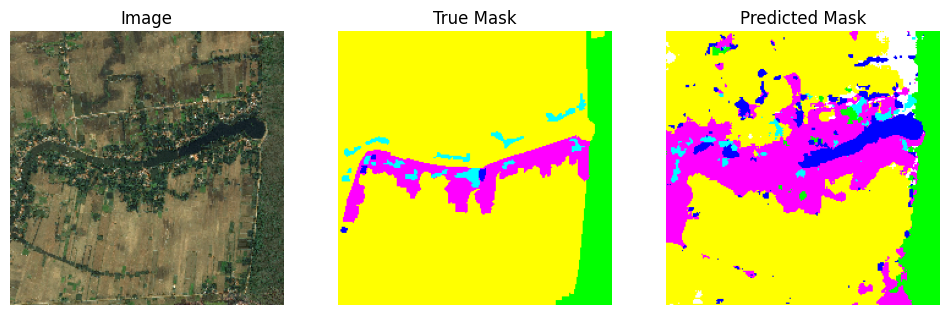

In [ ]:


# 7. Visualize predictions helper
def show_pred(i):
    img = X[i]
    true_mask = class_to_rgb(np.argmax(Y[i], axis=-1))
    pred = model.predict(np.expand_dims(img, 0), verbose=0)[0]
    pred_mask = class_to_rgb(np.argmax(pred, axis=-1))

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask)
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask)
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()

print("Showing predictions for 3 random images:")
for i in np.random.choice(len(X), 3, replace=False):
    show_pred(i)


In [ ]:

# 8. Save the model
model.save('deepglobe_unet_jay.keras')

# For Colab: download saved model (optional)
try:
    from google.colab import files
    files.download('deepglobe_unet_jay.keras')
except:
    print("File download skipped (not running in Colab).")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>